# Init Notebook

- Define necessary imports
- Initialise logging
- Initialize environment variables

In [54]:

from dotenv import load_dotenv
from openai import OpenAI
import os
from sentence_transformers import SentenceTransformer
from tqdm.autonotebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
import logging
from tqdm.autonotebook import tqdm
import pandas as pd

# Load environment variables from .env file
load_dotenv()

# Set up logging
logging.basicConfig(level=logging.INFO)
logging.getLogger().setLevel(logging.INFO)

logging.info("Logging initiated")

# Set up OpenAI API
open_ai_key = os.environ["OPEN_AI_KEY"]

# Define whether to use cached data
use_cache = False

INFO:root:Logging initiated


# Initialize Open AI client

Open AI client will be used to augment wiki data with generated question

In [38]:
from utils.llm_clients.cached_client import CachedLLMClient
from utils.llm_clients.cost_monitoring import LLMClientWithCostMonitoring
from utils.llm_clients.providers.open_ai_client import OpenAIClient
from utils.llm_clients.providers import supported_models

openai_client = OpenAIClient(api_key=open_ai_key, model_info=supported_models.GPT_4O)
openai_client = CachedLLMClient(client=openai_client)
openai_client = LLMClientWithCostMonitoring(client=openai_client)

# Data curation
Downloading set of articles to be used for the assessment

In [42]:
from pathlib import Path
import utils.wiki_parser.wiki_parser as wiki_parser
from pprint import pprint
from utils.storage import ArticleStorage
import os

storage = ArticleStorage()

data_files = os.listdir("data")
pbar = tqdm(total = len(data_files))
for filename in os.listdir("data"):
    pbar.set_description(f'Processing {filename}')
    if filename.endswith(".xml"):
        raw_pages = wiki_parser.extract_articles_from_file("data/" + filename, output_folder=Path("data"))
        storage.save_articles(raw_pages)
    pbar.update(1)

pages_df = storage.load_all()

  0%|          | 0/23 [00:00<?, ?it/s]

# Data filtering

Remove sections that don't contain text or are not relevant

In [43]:
pages_df = storage.load_all()
pages_df = pages_df[pages_df['Section Title'] != 'Linki zewnętrzne']
pages_df = pages_df[pages_df['Section Title'] != 'Zobacz też']
pages_df = pages_df[pages_df['Section Title'] != 'Bibliografia']
pages_df = pages_df[pages_df['Section Title'] != 'Przypisy']
pages_df = pages_df.drop_duplicates()
pages_df = pages_df.reset_index(drop=True)
pages_df['Section With Context'] = pages_df['Article Title'] + '\n' + pages_df['Section Title'] + '\n' + pages_df['Section Content']
pages_df.loc[pages_df['Section Title'] == 'Main', 'Section With Context'] = pages_df['Article Title'] + '\n' + pages_df['Section Content']
pages_df.head()

,Article Title,Section Title,Section Content,Section With Context
0,Protohistoria,Main,Protohistoria – termin określający dzieje społ...,Protohistoria\nProtohistoria – termin określaj...
1,Polityka historyczna,Main,Polityka historyczna () lub polityka pamięci –...,Polityka historyczna\nPolityka historyczna () ...
2,Polityka historyczna,Geneza pojęcia,Polityka historyczna wynika z potrzeby mitolog...,Polityka historyczna\nGeneza pojęcia\nPolityka...
3,Polityka historyczna,Narzędzia polityki historycznej,Narzędziami polityki historycznej są finansowa...,Polityka historyczna\nNarzędzia polityki histo...
4,Polityka historyczna,Zagadnienie polityki historycznej w Polsce,"Także po okresie PRL, kiedy to wdrażano stosow...",Polityka historyczna\nZagadnienie polityki his...


# Data Augmentation

In [44]:
from utils.question_generation import BASE_PROMT_PL, generate_question_for_text
from tqdm.auto import tqdm
from time import sleep

logging.getLogger("httpx").setLevel(logging.WARNING)

pbar = tqdm(total=len(pages_df))
questions_column = []

promt_tokens_bar = tqdm(desc="Promt cost ($): ")
completions_tokens_bar = tqdm(desc="Completions cost ($):")

for _, row in pages_df.iterrows():
    pbar.set_description(f"Generating questions for {row['Article Title']}/{row['Section Title']}")
    questions = generate_question_for_text(openai_client, row['Section With Context'], BASE_PROMT_PL)
    questions_column.append(questions.questions)
    pbar.update(1)
    promt_tokens_bar.update(openai_client.get_total_promt_cost() - promt_tokens_bar.n)
    completions_tokens_bar.update(openai_client.get_total_completion_cost() - completions_tokens_bar.n)

pages_df['questions'] = questions_column

  0%|          | 0/1653 [00:00<?, ?it/s]

Promt cost ($): : 0it [00:00, ?it/s]

Completions cost ($):: 0it [00:00, ?it/s]

# Data Ingestion

## Ingestion of data into the database

In [48]:
from utils.embedding_models.providers import hugging_face
from utils.embedding_models.providers import open_ai
from utils.embedding_models.providers import supported_models
from utils.vectordb.vectordb import VectorDB

logging.getLogger("httpx").setLevel(logging.WARNING)

# Define embedding models
embedding_models = {
    "HF_SDADAS": hugging_face.init_model(model_info=supported_models.ST_POLISH_PARAPHRASE_FROM_DISTILROBERTA),
    "OPENAI_SMALL": open_ai.init_model(api_key=open_ai_key, model_info=supported_models.TEXT_EMBEDDING_3_SMALL),
    "OPENAI_LARGE": open_ai.init_model(api_key=open_ai_key, model_info=supported_models.TEXT_EMBEDDING_3_LARGE),
    "OPENAI__ADA": open_ai.init_model(api_key=open_ai_key, model_info=supported_models.TEXT_EMBEDDING_ADA_002),
    "HF_MPNET": hugging_face.init_model(model_info=supported_models.ST_POLISH_PARAPHRASE_FROM_MPNET),
    "HF_KARTONBERTA": hugging_face.init_model(model_info=supported_models.ORB_ST_POLISH_KARTONBERTA_BASE_ALPHA_V1),
}

# Initialize vector database and add indices (one per each embedding model)
vector_db = VectorDB()
for index_name, index in embedding_models.items():
    vector_db.add_index(index_name, index)

# Populate each index with data
sections = pages_df['Section With Context'].values.tolist()
for index_name in vector_db.list_indices():
    cost_bar = tqdm(desc=f'{index_name}. Total cost ($)')
    model = embedding_models[index_name]
    for text in tqdm(sections, desc=f'{index_name}. Processed items'):
        vector_db.insert_text(text, index_name)
        cost_bar.update(model.get_total_cost() - cost_bar.n)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sdadas/st-polish-paraphrase-from-distilroberta


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sdadas/st-polish-paraphrase-from-mpnet
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: OrlikB/st-polish-kartonberta-base-alpha-v1


HF_SDADAS. Total cost ($): 0it [00:00, ?it/s]

HF_SDADAS. Processed items:   0%|          | 0/1653 [00:00<?, ?it/s]

OPENAI_SMALL. Total cost ($): 0it [00:00, ?it/s]

OPENAI_SMALL. Processed items:   0%|          | 0/1653 [00:00<?, ?it/s]

OPENAI_LARGE. Total cost ($): 0it [00:00, ?it/s]

OPENAI_LARGE. Processed items:   0%|          | 0/1653 [00:00<?, ?it/s]

OPENAI__ADA. Total cost ($): 0it [00:00, ?it/s]

OPENAI__ADA. Processed items:   0%|          | 0/1653 [00:00<?, ?it/s]

HF_MPNET. Total cost ($): 0it [00:00, ?it/s]

HF_MPNET. Processed items:   0%|          | 0/1653 [00:00<?, ?it/s]

HF_KARTONBERTA. Total cost ($): 0it [00:00, ?it/s]

HF_KARTONBERTA. Processed items:   0%|          | 0/1653 [00:00<?, ?it/s]

## Ingestion cost

In [49]:
embeddings_costs = [{"Model" : model.model_info.model_name, "Cost ($)": model.get_total_cost()} for model in embedding_models.values()]
embeddings_costs_df = pd.DataFrame(embeddings_costs)
embeddings_costs_df

,Model,Cost ($)
0,sdadas/st-polish-paraphrase-from-distilroberta,0.000000
1,text-embedding-3-small,0.014802
2,text-embedding-3-large,0.096215
3,text-embedding-ada-002,0.074012
4,sdadas/st-polish-paraphrase-from-mpnet,0.000000
5,OrlikB/st-polish-kartonberta-base-alpha-v1,0.000000


# Model Evaluation

## Running the evaluation

In [91]:
from tqdm.autonotebook import tqdm

test_df = pages_df.copy()[:400]

evaluatiion_results = []

for index_name in vector_db.list_indices():
    model = embedding_models[index_name]
    cost = model.get_total_cost()
    embedding_tokens_bar = tqdm(desc=f"{index_name}. Embedding cost ($): ")

    for k in [1, 5, 10]:
        for _, row in tqdm(list(test_df.iterrows()), desc=f"{index_name}. k={k}. Wiki sections: "):
            matched_with_answer = 0
            for question in row['questions']:
                found_text = vector_db.find_text(text=question, top_k=k, index_name=index_name)

                # if row['Section With Context'] in found_text:
                #     matched_with_answer += 1
                
                embedding_tokens_bar.update(model.get_total_cost() - cost - embedding_tokens_bar.n)
                evaluatiion_results.append({
                    "Model Name": index_name,
                    "k": k,
                    "Section": row['Section With Context'],
                    "Question": question,
                    "Found text": found_text,
                    "Matched with answer": row['Section With Context'] in found_text
                })

HF_SDADAS. Embedding cost ($): : 0it [00:00, ?it/s]

HF_SDADAS. k=1. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

HF_SDADAS. k=5. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

HF_SDADAS. k=10. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

OPENAI_SMALL. Embedding cost ($): : 0it [00:00, ?it/s]

OPENAI_SMALL. k=1. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

OPENAI_SMALL. k=5. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

OPENAI_SMALL. k=10. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

OPENAI_LARGE. Embedding cost ($): : 0it [00:00, ?it/s]

OPENAI_LARGE. k=1. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

OPENAI_LARGE. k=5. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

OPENAI_LARGE. k=10. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

OPENAI__ADA. Embedding cost ($): : 0it [00:00, ?it/s]

OPENAI__ADA. k=1. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

OPENAI__ADA. k=5. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

OPENAI__ADA. k=10. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

HF_MPNET. Embedding cost ($): : 0it [00:00, ?it/s]

HF_MPNET. k=1. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

HF_MPNET. k=5. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

HF_MPNET. k=10. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

HF_KARTONBERTA. Embedding cost ($): : 0it [00:00, ?it/s]

HF_KARTONBERTA. k=1. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

HF_KARTONBERTA. k=5. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

HF_KARTONBERTA. k=10. Wiki sections:   0%|          | 0/400 [00:00<?, ?it/s]

In [180]:
evaluatiion_results_df = pd.DataFrame(evaluatiion_results)
evaluatiion_results_df = evaluatiion_results_df.pivot_table(index=['Section', 'Question', 'Model Name'], columns=['k'], values=['Matched with answer'], aggfunc='sum').add_prefix('k=')
evaluatiion_results_df = evaluatiion_results_df.droplevel(0, axis=1).reset_index()
evaluatiion_results_df.head()

k,Section,Question,Model Name,k=1,k=5,k=10
0,Anachoretyzm\nAnachoretyzm (z anachoreo – „odd...,Jak anachoretyzm przyczynił się do rozwoju for...,HF_KARTONBERTA,0,1,1
1,Anachoretyzm\nAnachoretyzm (z anachoreo – „odd...,Jak anachoretyzm przyczynił się do rozwoju for...,HF_MPNET,0,0,0
2,Anachoretyzm\nAnachoretyzm (z anachoreo – „odd...,Jak anachoretyzm przyczynił się do rozwoju for...,HF_SDADAS,0,0,1
3,Anachoretyzm\nAnachoretyzm (z anachoreo – „odd...,Jak anachoretyzm przyczynił się do rozwoju for...,OPENAI_LARGE,1,1,1
4,Anachoretyzm\nAnachoretyzm (z anachoreo – „odd...,Jak anachoretyzm przyczynił się do rozwoju for...,OPENAI_SMALL,1,1,1


## Average number of questions correctly answered

In [134]:
questions_per_section_df = evaluatiion_results_df.groupby(['Section', 'Model Name'])[['k=1', 'k=5', 'k=10']].sum()
meand_qs_df = questions_per_section_df.groupby('Model Name').mean().reset_index()
errors_df = questions_per_section_df.groupby('Model Name').std().reset_index()
meand_qs_df.set_index('Model Name', inplace=True)

meand_qs_df = meand_qs_df.sort_values(by='k=1', ascending=True)
errors_df = errors_df.set_index('Model Name').reindex(meand_qs_df.index)

meand_qs_df.head()

k,k=1,k=5,k=10
Model Name,,,
HF_SDADAS,3.0950,4.3375,4.6275
HF_MPNET,3.1925,4.3675,4.5925
OPENAI__ADA,3.4675,4.6000,4.7950
HF_KARTONBERTA,3.6150,4.6650,4.8150
OPENAI_SMALL,3.6700,4.6875,4.8550


In [ ]:
errors_df.head()

k,k=1,k=5,k=10
Model Name,,,
HF_SDADAS,1.421628,0.911411,0.703549
HF_MPNET,1.398332,0.932533,0.733340
OPENAI__ADA,1.326024,0.675382,0.508548
HF_KARTONBERTA,1.282922,0.654864,0.491303
OPENAI_SMALL,1.262968,0.667801,0.446625


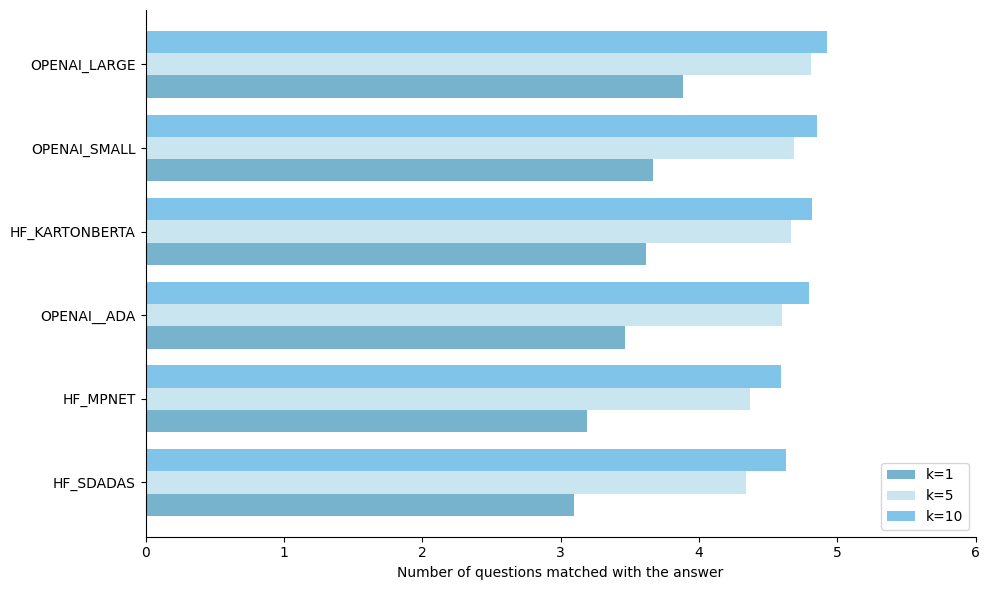

In [145]:
axes = meand_qs_df.plot(y=['k=1', 'k=5', 'k=10'], kind="barh", 
                        width=0.8, figsize=(10, 6), 
                        color=['#78B3CE', '#C9E6F0', '#80C4E9'],
                        # xerr=errors_df[['k=1', 'k=5', 'k=10']]
                        # color = ['#696969', '#909090', '#C8C8C8']
                        )
axes.legend(loc='lower right')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_xlim(0, 6)

y_axis = axes.get_yaxis()
y_label = y_axis.get_label()
y_label.set_visible(False)

x_axis = axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(True)
x_label.set_text("Number of questions matched with the answer")

plt.tight_layout()

## Total number of questions correctly answered

In [189]:
total_qs_df = evaluatiion_results_df.groupby(['Model Name'])[['k=1', 'k=5', 'k=10']].sum()
total_qs_df = total_qs_df.sort_values(by='k=1', ascending=True)
total_qs_df

k,k=1,k=5,k=10
Model Name,,,
HF_SDADAS,1238,1735,1851
HF_MPNET,1277,1747,1837
OPENAI__ADA,1387,1840,1918
HF_KARTONBERTA,1446,1866,1926
OPENAI_SMALL,1468,1875,1942
OPENAI_LARGE,1554,1925,1969


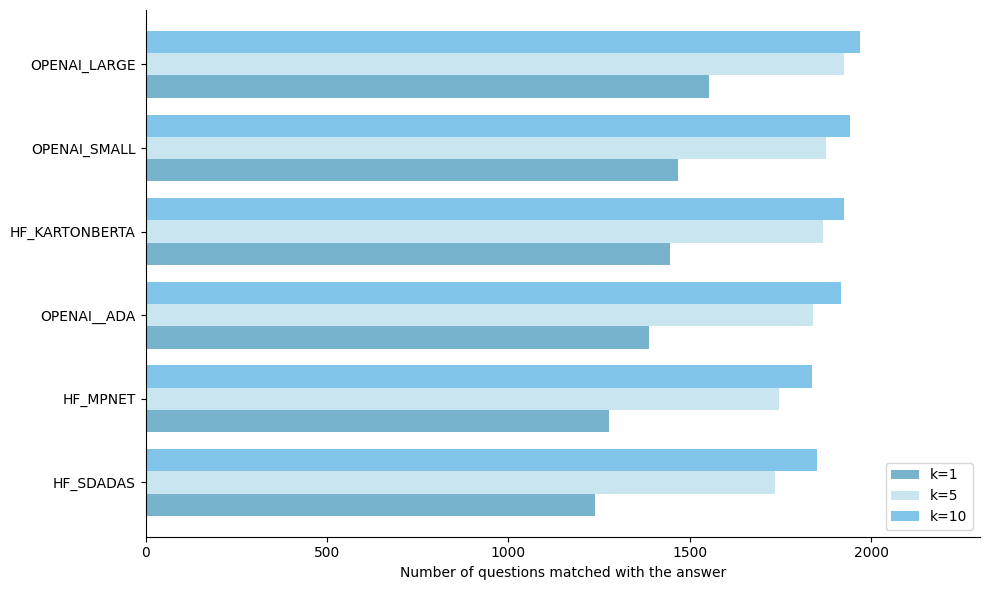

In [190]:
axes = total_qs_df.plot(y=['k=1', 'k=5', 'k=10'], kind="barh", 
                        width=0.8, figsize=(10, 6), 
                        color=['#78B3CE', '#C9E6F0', '#80C4E9'],
                        # xerr=errors_df[['k=1', 'k=5', 'k=10']]
                        # color = ['#696969', '#909090', '#C8C8C8']
                        )
axes.legend(loc='lower right')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_xlim(0, 2300)

y_axis = axes.get_yaxis()
y_label = y_axis.get_label()
y_label.set_visible(False)

x_axis = axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(True)
x_label.set_text("Number of questions matched with the answer")

plt.tight_layout()